<a href="https://colab.research.google.com/github/dcastf01/object_detection_TFM/blob/main/Data_analisis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook to study the datasets

In [ ]:
#@title Tarjeta ofrecida por nvidia
!nvidia-smi

In [ ]:
#@title Descargar repositorios e instalar librerias
# %%capture

import time
import pathlib

import os
import pandas as pd
import tqdm


start_time = time.time()
!git clone https://github.com/dcastf01/colab_utils.git
!git clone https://github.com/dcastf01/object_detection_TFM.git
!pip install git+https://github.com/tensorflow/examples.git
!pip install tensorflow-addons
!pip install -U tfds-nightly
!pip install pydub
!pip install opencv-python-headless==4.2.0.34
!pip install tf_slim
!pip install pycocotools
# Clone the tensorflow models repository if it doesn't already exist

##Descargar y crear dataframe

##Compcars

In [ ]:
from object_detection_TFM.dataset.compcars import compcar_analisis

In [ ]:
path_txt="/content/object_detection_TFM/dataset/compcars/id_drive_to_download.txt"
images_path="/content/data/image"
label_path="/content/data/label"
filename_csv_with_data="/content/object_detection_TFM/dataset/compcars/all_information_compcars.csv"

In [ ]:
%%time
from colab_utils.utils.download_files import download_file_from_google_drive,generate_id_destination_to_download
for id, destination in generate_id_destination_to_download(path_txt).items():
  download_file_from_google_drive(id,destination)
!bash /content/object_detection_TFM/dataset/compcars/unzip_remove_files.sh

In [ ]:
%%time
df=compcar_analisis.get_df_from_files(images_path,label_path)

In [ ]:
#@title Exportar dataframe
df.to_csv(filename_csv_with_data)

In [ ]:
#@title Cargar dataframe from csv
from object_detection_TFM.dataset.compcars.compcar_analisis import set_type_data_compcars
df=pd.read_csv(filename_csv_with_data,index_col =[0])
df=set_type_data_compcars(df)
df["extra"]=df["model_id"].astype(str)+df["released_year"].astype(str)

In [ ]:
from object_detection_TFM.dataset.analisis_dataset import create_pareto_diagram

In [ ]:
create_pareto_diagram(df,"viewpoint")


Debido a que la categoría 4 ( frontales algo ladeadas) y la categoría 1 (frontales) suman más que la 5 y la dos optaremos por utilizar imágenes frontales.

In [ ]:
create_pareto_diagram(df,"make_id")

Se observa el desbalanceo que existe de imagenes respecto al año de fabricación, por lo que para normalizar los datos se optará a quitar está variable

In [ ]:
create_pareto_diagram(df,"model_id")

Se observa cierto desbalanceo de imágenes por lo que habrá que aplicar en el entrenamiento alguna técnica para equilibrar los pesos de la red

In [ ]:
create_pareto_diagram(df,"released_year")

Se observa el desbalanceo que existe de imagenes respecto al año de fabricación, por lo que para normalizar los datos se optará a quitar está variable

##cars196

In [ ]:
from dataset.cars196 import cars196
import tensorflow_datasets as tfds

path_images= r"data\cars196" 

cars196.Cars196()
cars_builder=tfds.builder("cars196")
cars_builder.download_and_prepare(download_dir=path_images)

In [ ]:
cars_builder.data_dir


Solo se analizarán las imágenes de entrenamiento debido a que de las imágenes de Test no se han encontrado las etiquetas y se desea hacer una análisis rápido

In [12]:
data_annotations_path_train=r"data\cars196\extracted\TAR_GZ.ai.stanford.edu_jkrause_cars_car_devkituX3rRjr31Ytr-qGLKk3pgp8PeejOZj36kmG_eBDprM0.tgz\devkit\cars_train_annos.mat"
import pandas as pd
import tensorflow as tf

# image_dict = returnImageDict(path_train)

# bbox_dict = returnBbox(data_annotations_path_train, image_dict)
'''
-cars_train_annos.mat:
  Contains the variable 'annotations', which is a struct array of length
  num_images and where each element has the fields:
    bbox_x1: Min x-value of the bounding box, in pixels
    bbox_x2: Max x-value of the bounding box, in pixels
    bbox_y1: Min y-value of the bounding box, in pixels
    bbox_y2: Max y-value of the bounding box, in pixels
    class: Integral id of the class the image belongs to.
    fname: Filename of the image within the folder of images.
'''
def create_dataframe_cars196(data_annotations):
  df=pd.DataFrame()


  with tf.io.gfile.GFile(data_annotations, 'rb') as f:
    mat = tfds.core.lazy_imports.scipy.io.loadmat(f)
    for example in mat['annotations'][0]:
      image_name = example[-1].item().split('.')[0]
      label = cars196._NAMES[example[4].item() - 1]

      features = {
            'label': label,
            'filename':str(image_name),
        }
      df=df.append(features,ignore_index=True)  
  return df
df=create_dataframe_cars196(data_annotations_path_train)
# df_test=create_dataframe_cars196(data_annotations_path_test) 


A través de label se generan las características make, model y released para hacer una similitud con el dataset anterior

In [13]:
df["make_id"]=df.label.str.split(" ").str[0]
df["model_id"]=df.label.str.split(" ").str[1:-1].str.join(" ")
df["released_year"]=df.label.str.split(" ").str[-1]
df

,filename,label,make_id,model_id,released_year
0,00001,Audi TTS Coupe 2012,Audi,TTS Coupe,2012
1,00002,Acura TL Sedan 2012,Acura,TL Sedan,2012
2,00003,Dodge Dakota Club Cab 2007,Dodge,Dakota Club Cab,2007
3,00004,Hyundai Sonata Hybrid Sedan 2012,Hyundai,Sonata Hybrid Sedan,2012
4,00005,Ford F-450 Super Duty Crew Cab 2012,Ford,F-450 Super Duty Crew Cab,2012
...,...,...,...,...,...
8139,08140,Chrysler Town and Country Minivan 2012,Chrysler,Town and Country Minivan,2012
8140,08141,smart fortwo Convertible 2012,smart,fortwo Convertible,2012
8141,08142,Mercedes-Benz SL-Class Coupe 2009,Mercedes-Benz,SL-Class Coupe,2009
8142,08143,Ford GT Coupe 2006,Ford,GT Coupe,2006


Destacar que no se tiene en ningún momento el viewpoint el cual es muy útil

In [14]:
from dataset.analisis_dataset import create_pareto_diagram

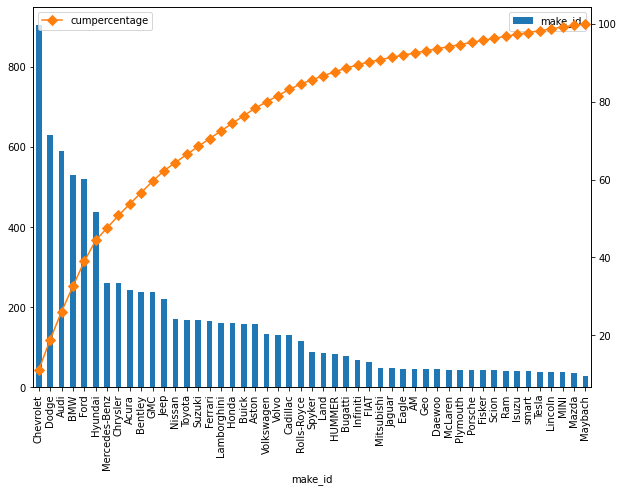

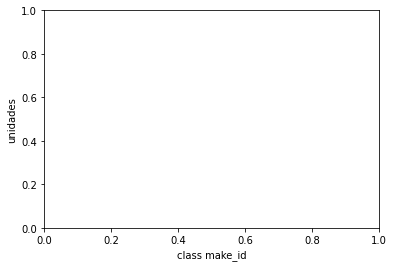

In [15]:
create_pareto_diagram(df,"make_id")

In [ ]:
create_pareto_diagram(df,"model_id")

In [ ]:
create_pareto_diagram(df,"released_year")

In [ ]:
data=df["viewpoint"].value_counts()

In [ ]:
data.sort_values()